Building a First Model
- In the last notebook we loaded in the data from retrosheet and did some processing to get the team level statistics.
- We saved that data to a file called 'df_bp1.csv'
- In this notebook, we will load in that data, do some initital data exploration, and then build and evaluate our first predictive model

In [ ]:
# Uncomment if you need to install any of the following packages
# %pip install lightgbm
# %pip install ml_insights --upgrade
# %pip install structureboost

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

  Using cached lightgbm-4.3.0-py3-none-macosx_13_0_arm64.whl
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
df=pd.read_csv('df_bp1.csv')

/var/folders/9d/8vjj2hs92bq3s8th__4v3jfh0000gn/T/ipykernel_56559/3742704531.py:1: DtypeWarning: Columns (13,14,15,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('df_bp1.csv')


Data Checks / Exploration

In [11]:
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75939 entries, 0 to 75938
Data columns (total 194 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    date                  75939 non-null  int64  
 1    dblheader_code        75939 non-null  int64  
 2    day_of_week           75939 non-null  object 
 3    team_v                75939 non-null  object 
 4    league_v              75939 non-null  object 
 5    game_no_v             75939 non-null  int64  
 6    team_h                75939 non-null  object 
 7    league_h              75939 non-null  object 
 8    game_no_h             75939 non-null  int64  
 9    runs_v                75939 non-null  int64  
 10   runs_h                75939 non-null  int64  
 11   outs_total            75939 non-null  int64  
 12   day_night             75939 non-null  object 
 13   completion_info       55 non-null     object 
 14   forfeit_info          1 non-null      object 
 15   

In [14]:
df.season.value_counts().sort_index().head(10)

season
1990    2105
1991    2104
1992    2106
1993    2269
1994    1600
1995    2017
1996    2267
1997    2266
1998    2432
1999    2428
Name: count, dtype: int64

In [13]:
hv_mean = df.home_victory.mean()
hv_mean

0.5377605709846061

In [15]:
df.run_diff.value_counts()

run_diff
 1     13118
-1      8527
 2      7073
-2      6763
 3      5654
-3      5324
 4      4390
-4      4266
 5      3174
-5      3145
 6      2378
-6      2240
-7      1647
 7      1631
 8      1206
-8      1079
 9       812
-9       754
 10      517
-10      511
 11      345
-11      305
 12      204
-12      186
-13      147
 13      140
 14       80
-14       79
 15       43
-15       41
-16       35
 16       30
 17       16
-17       13
 0        13
-18       11
 18        8
 19        8
 21        6
-19        6
-21        4
 20        3
-20        3
 22        1
-22        1
-27        1
-23        1
Name: count, dtype: int64

In [16]:
df.outs_total.value_counts()

outs_total
51     34495
54     31723
60      1490
53      1426
52      1274
66       794
58       671
59       625
72       414
57       346
64       330
65       315
78       225
70       196
63       176
71       149
84       119
39       116
42       115
77        99
76        92
69        92
75        60
82        60
90        52
83        50
89        36
96        32
48        26
36        26
30        23
45        21
81        20
88        18
94        16
33        16
102       14
41        13
31        13
108       12
40        11
95        10
46         9
87         8
93         8
27         7
37         7
38         7
100        6
44         6
106        6
43         6
47         5
101        5
32         5
28         4
34         4
111        4
113        4
114        4
29         3
105        3
107        3
120        3
50         2
112        2
35         1
129        1
118        1
55         1
49         1
132        1
99         1
Name: count, dtype: int64

In [17]:
df.home_victory[df.outs_total==53].mean()

0.9992987377279102

lets look for the game this happened.

In [18]:
df.loc[(df.outs_total==53) & (df.home_victory!=1),:]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v
35921,20050915,0,Thu,SLN,NL,148,CHN,NL,147,6,1,53,N,NaN,NaN,NaN,CHI11,37849.0,167,300000030,000000001,33,9,1,0,0,5,0,1,0,5,0,6,0,1,1,0,6,2,1,1,1,0,26,12,1,0,1,0,33,8,0,0,1,1,0,0,0,2,0,8,0,0,1,0,8,3,5,5,0,0,27,13,1,0,2,0,wolfj901,Jim Wolf,holbs901,Sam Holbrook,vanol901,Larry Vanover,marsr901,Randy Marsh,NaN,(none),NaN,(none),larut101,Tony LaRussa,baked002,Dusty Baker,suppj001,Jeff Suppan,priom001,Mark Prior,NaN,(none),walkl001,Larry Walker,suppj001,Jeff Suppan,priom001,Mark Prior,ecksd001,David Eckstein,6,edmoj001,Jim Edmonds,8,pujoa001,Albert Pujols,3,walkl001,Larry Walker,9,rodrj002,John Rodriguez,7,nunea001,Abraham Nunez,5,moliy001,Yadier Molina,2,lunah001,Hector Luna,4,suppj001,Jeff Suppan,1,hairj002,Jerry Hairston,8,walkt002,Todd Walker,4,lee-d002,Derrek Lee,3,garcn001,Nomar Garciaparra,5,burnj001,Jeromy Burnitz,9,murtm001,Matt Murton,7,peren001,Neifi Perez,6,blanh001,Henry Blanco,2,priom001,Mark Prior,1,NaN,Y,2005,-5,0,7,200509150,0.268813,0.270416,0.323345,0.334703,0.439957,0.424193,0.763303,0.758897,63.0,88.0,36.0,37.0,98.0,99.0,0.271073,0.263467,0.322351,0.32737,0.444444,0.39569,0.766795,0.723061,12.0,20.0,6.0,5.0,15.0,23.0


In [19]:
df.game_no_h.value_counts().sort_index()

game_no_h
1      483
2      483
3      487
4      483
5      479
6      483
7      484
8      493
9      493
10     487
11     477
12     469
13     479
14     482
15     487
16     493
17     490
18     482
19     500
20     486
21     477
22     482
23     478
24     474
25     467
26     482
27     486
28     489
29     490
30     492
31     500
32     501
33     488
34     486
35     477
36     474
37     462
38     463
39     475
40     486
41     501
42     492
43     494
44     486
45     494
46     495
47     480
48     472
49     476
50     471
51     463
52     480
53     482
54     495
55     500
56     480
57     476
58     481
59     496
60     496
61     471
62     468
63     463
64     468
65     470
66     485
67     474
68     461
69     470
70     455
71     454
72     462
73     467
74     473
75     471
76     495
77     484
78     470
79     475
80     463
81     463
82     459
83     457
84     473
85     473
86     481
87     462
88     453
89     466
90     456


Moral of the Story: Interrogate your data!
- Ask questions
- Make hypotheses
- Dig into details to confirm or disprove them

Begin Modeling

In [20]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018)]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [21]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [22]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [23]:
X_train.shape, X_valid.shape, X_test.shape, 

((67740, 4), (3327, 4), (4859, 4))

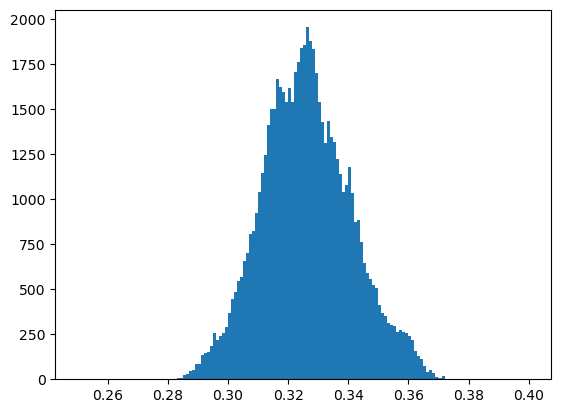

In [24]:
plt.hist(X_train.OBP_162_h, np.linspace(.25,.4,151));

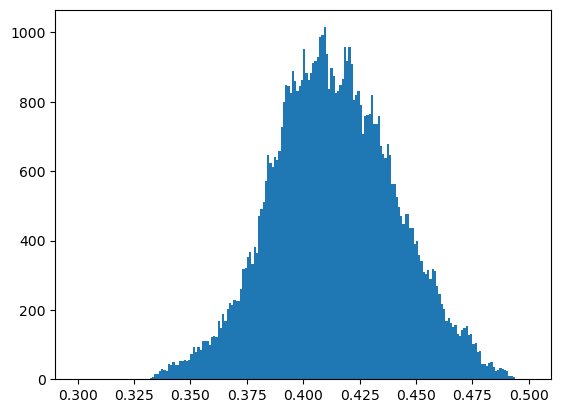

In [25]:
plt.hist(X_train.SLG_162_v, np.linspace(.3,.5,201));

In [26]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 36446, number of negative: 31294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 67740, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538028 -> initscore=0.152405
[LightGBM] [Info] Start training from score 0.152405
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689245
[20]	valid_0's binary_logloss: 0.68817
[30]	valid_0's binary_logloss: 0.687211
[40]	valid_0's binary_logloss: 0.686325
[50]	valid_0's binary_logloss: 0.685595
[60]	valid_0's binary_logloss: 0.685039
[70]	valid_0's binary_logloss: 0.684508
[80]	valid_0's binary_logloss: 0.684064
[90]	valid_0's binary_logloss: 0.683641
[100]	valid_0's binary_logloss: 0.683326
[110]	valid_0's binary_logloss: 0.682943
[120]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [27]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [28]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6832496043939199, 0.6905412309480249)

In [29]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

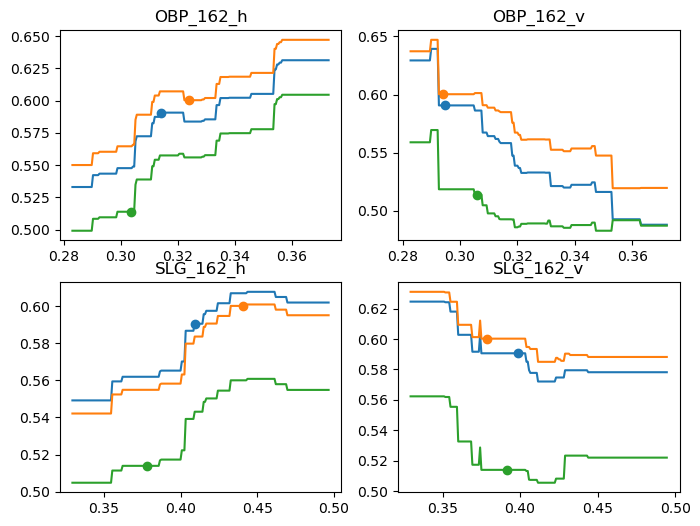

In [30]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=2)

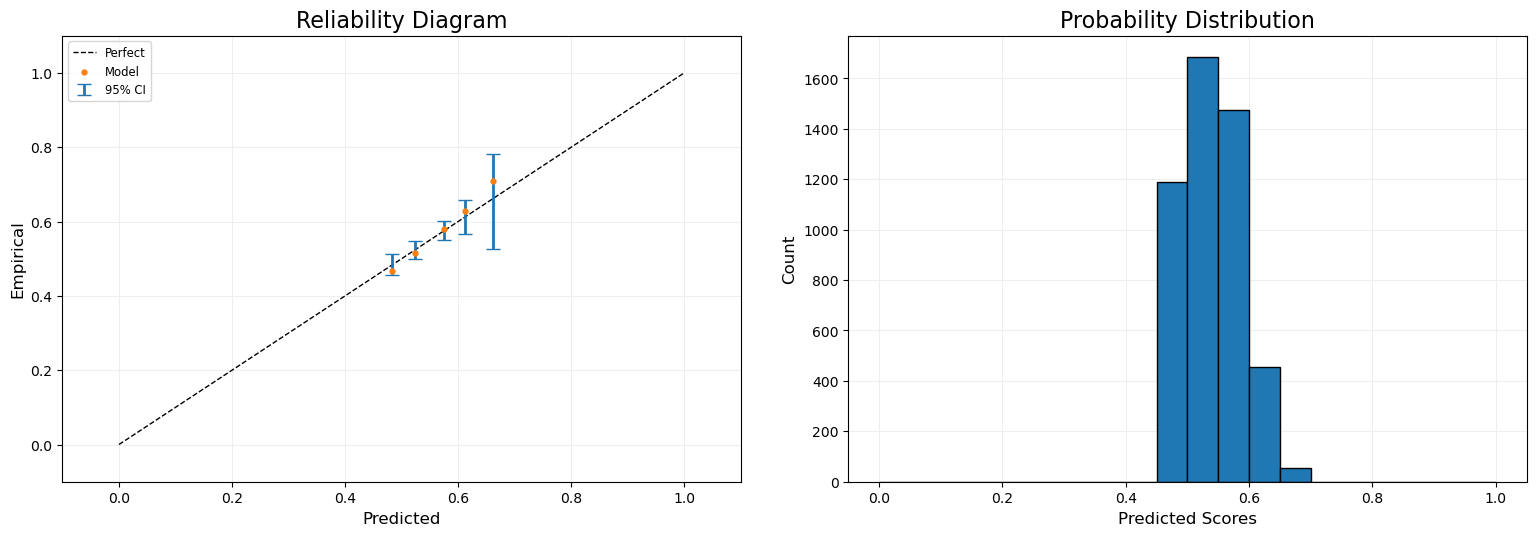

In [31]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [32]:
fc = stb.get_basic_config(X_train, stb.default_config_dict())

stb1 = stb.StructureBoost(max_depth=3, learning_rate=.02, feature_configs = fc, num_trees=2000)
stb1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5)

i=0, eval_set_loss = 0.6904362401840554
i=10, eval_set_loss = 0.6888492678603912
i=20, eval_set_loss = 0.6872789492269492
i=30, eval_set_loss = 0.6862372385635493
i=40, eval_set_loss = 0.6853749328674202
i=50, eval_set_loss = 0.6847889992850906
i=60, eval_set_loss = 0.6840422842082846
i=70, eval_set_loss = 0.6836089139260471
i=80, eval_set_loss = 0.6829147578180783
i=90, eval_set_loss = 0.6824933160070962
i=100, eval_set_loss = 0.6824790185590238
i=110, eval_set_loss = 0.6821581490880807
i=120, eval_set_loss = 0.6818765823593204
i=130, eval_set_loss = 0.681619609164042
i=140, eval_set_loss = 0.6813399339023433
i=150, eval_set_loss = 0.6814850475090852
i=160, eval_set_loss = 0.6814763715705338
i=170, eval_set_loss = 0.68131485230732
i=180, eval_set_loss = 0.6812048285777001
i=190, eval_set_loss = 0.6810513283576197
i=200, eval_set_loss = 0.6810530150198065
i=210, eval_set_loss = 0.6810851305493821
i=220, eval_set_loss = 0.6811217272463529
i=230, eval_set_loss = 0.6815952223118422
i=240,

In [33]:
preds_stb = stb1.predict(X_test)

In [34]:
log_loss(y_test, preds_stb), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6832199806807101, 0.6905412309480249)

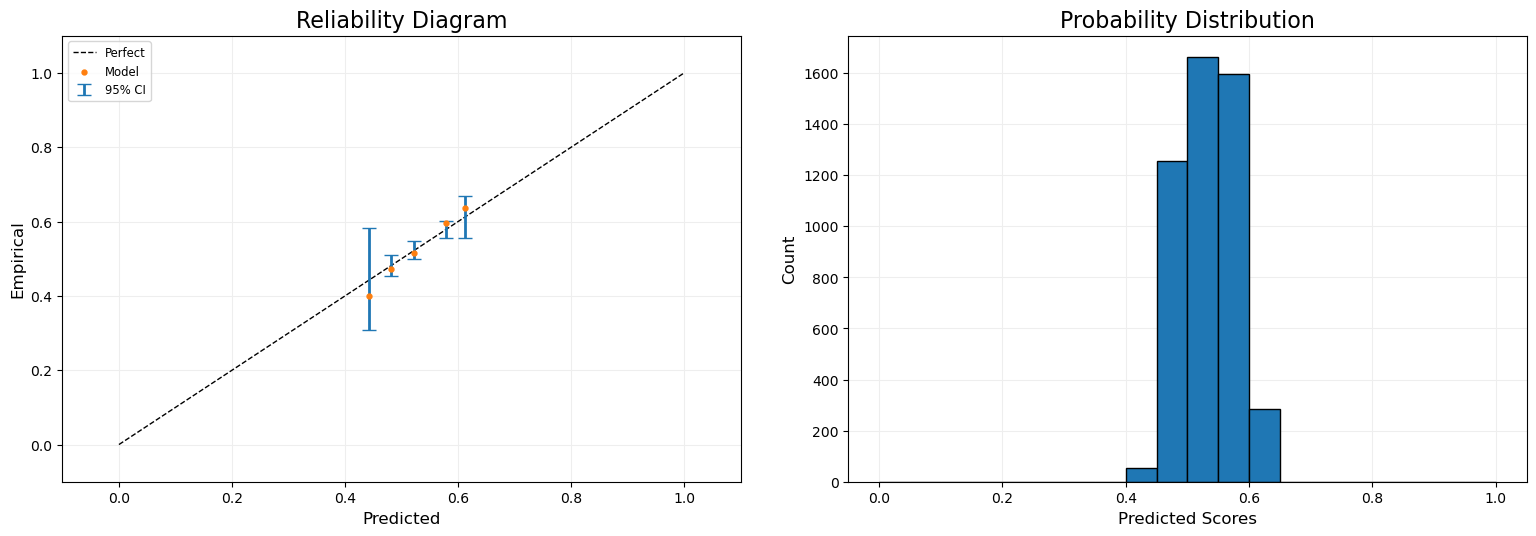

In [35]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_stb, show_histogram=True);

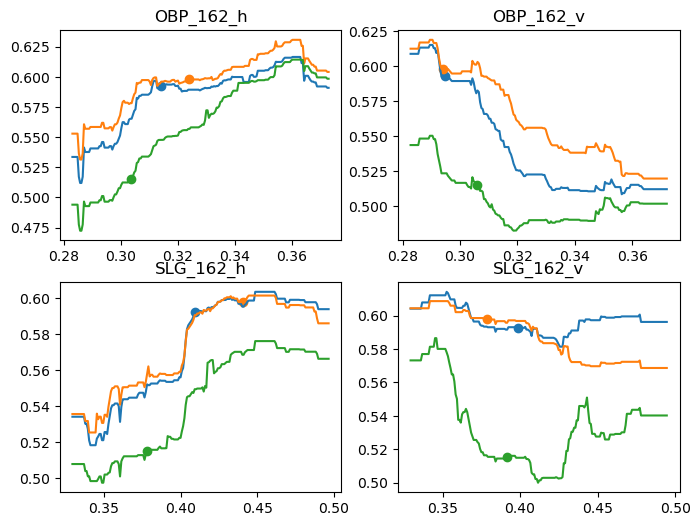

In [36]:
rd= mli.get_range_dict(X_train)
mli.ice_plot(stb1, plot_pts, X_test.columns, rd, plots_per_row=2)